In [16]:
# Librerías necesarias para el proyecto
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
# Carga y redimensionamiento de imágenes a 128x128 para su futuro escalamiento
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = Image.open(img_path).resize((128, 128))  
            img_array = np.array(img)
            images.append(img_array)
    return np.array(images)

In [18]:
# Rutas de las carpetas de entrenamiento, predicción y test
training_path = 'training'
test_path = 'test'
prediction_path = 'prediction'

In [19]:
# Cargar imágenes de cada una de las 6 subcarpetas
training_images = []
for subfolder in ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']:
    folder_path = os.path.join(training_path, subfolder)
    training_images.append(load_images_from_folder(folder_path))
training_images = np.concatenate(training_images, axis=0)

In [20]:
# Convertir imágenes a un arreglo bidimensional para aplicar el escalamiento
num_images, height, width, channels = training_images.shape
training_images_reshaped = training_images.reshape((num_images, -1))

# Aplicar Min-Max Scaling
scaler = MinMaxScaler()
training_images_scaled = scaler.fit_transform(training_images_reshaped)

# Regresar a la forma original para su uso en Red Neuronal posterior
training_images_scaled = training_images_scaled.reshape((num_images, height, width, channels))

In [21]:
test_images = []

# Recorrer cada subcarpeta dentro del directorio de test
for subfolder in ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']:
    folder_path = os.path.join(test_path, subfolder)
    test_images.append(load_images_from_folder(folder_path))


test_images = np.concatenate(test_images, axis=0)
num_images_test, height_test, width_test, channels_test = test_images.shape
test_images_reshaped = test_images.reshape((num_images_test, -1))

# Aplicar el mismo escalador Min-Max a las imágenes de prueba usando los parámetros de las imágenes de entrenamiento
test_images_scaled = scaler.transform(test_images_reshaped)
test_images_scaled = test_images_scaled.reshape((num_images_test, height_test, width_test, channels_test))


In [22]:
# Definir las etiquetas para cada subcarpeta
subfolders = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Cargar y codificar etiquetas para el conjunto de entrenamiento
training_labels = []
for label in subfolders:
    folder_path = os.path.join(training_path, label)
    num_files = len(os.listdir(folder_path))
    training_labels.extend([label] * num_files)
training_labels = np.array(training_labels)

# Ajustar el codificador de etiquetas
label_encoder = LabelEncoder()
training_labels_encoded = label_encoder.fit_transform(training_labels)

In [23]:
# Aumentación de datos
datagen = ImageDataGenerator(
							rescale = 1./255,
							rotation_range = 10,
							width_shift_range = 0.2,
						#	height_shift_range = 0.2,
						#	shear_range = 0.3,
							zoom_range = 0.3,
							horizontal_flip = True)
datagen.fit(training_images_scaled)

Found 14034 images belonging to 6 classes.


<Figure size 640x480 with 0 Axes>

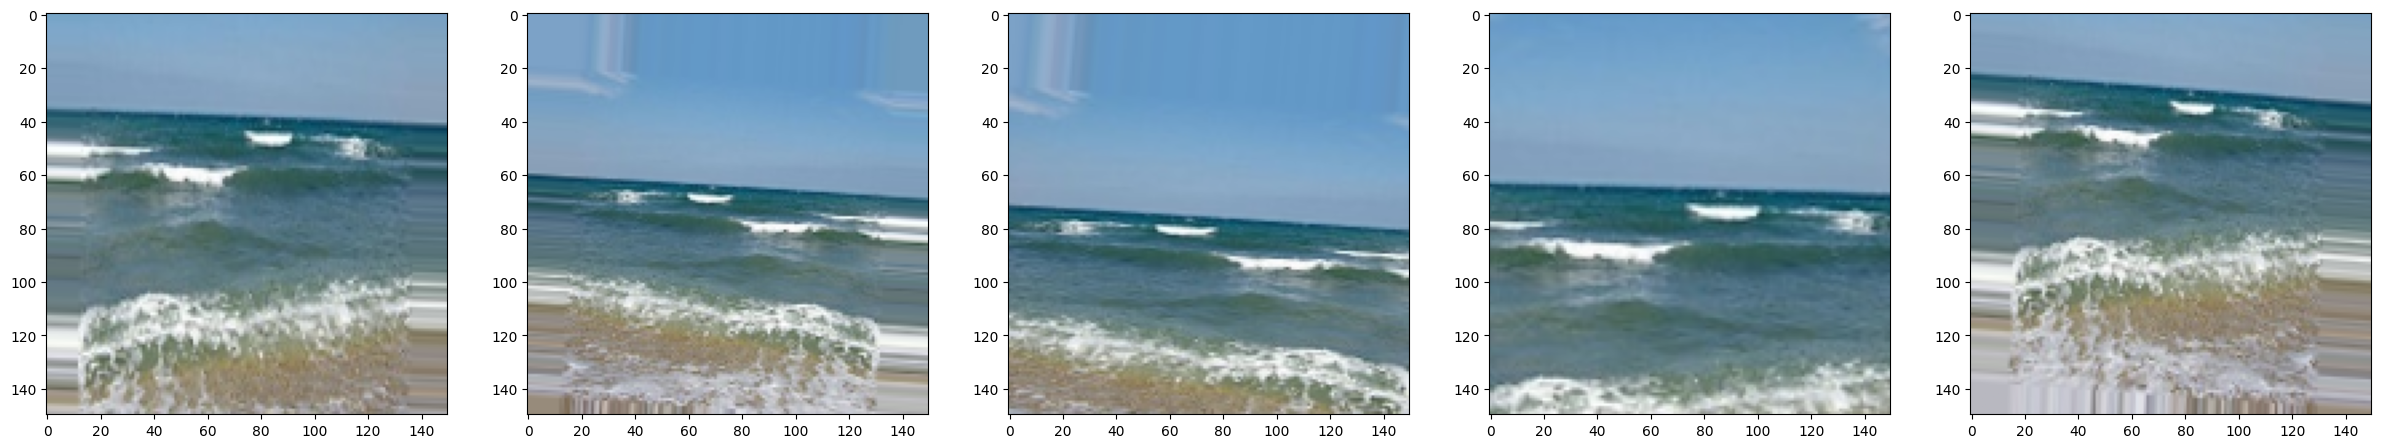

In [24]:
# Se crea un generador de datos a partir de un directorio de entrenamiento
train_generator = datagen.flow_from_directory(
							training_path,
							target_size = (150, 150),
							batch_size = 1,
							class_mode ='binary',
							)


plt.figure()
f, axarr = plt.subplots(1, 5, figsize=(30, 8))

for i in range(5) :
  axarr[i].imshow(train_generator[0][0][0])

Found 14034 images belonging to 6 classes.
(8, 150, 150, 3)
[5. 1. 4. 2. 1. 1. 3. 3.]


<Figure size 640x480 with 0 Axes>

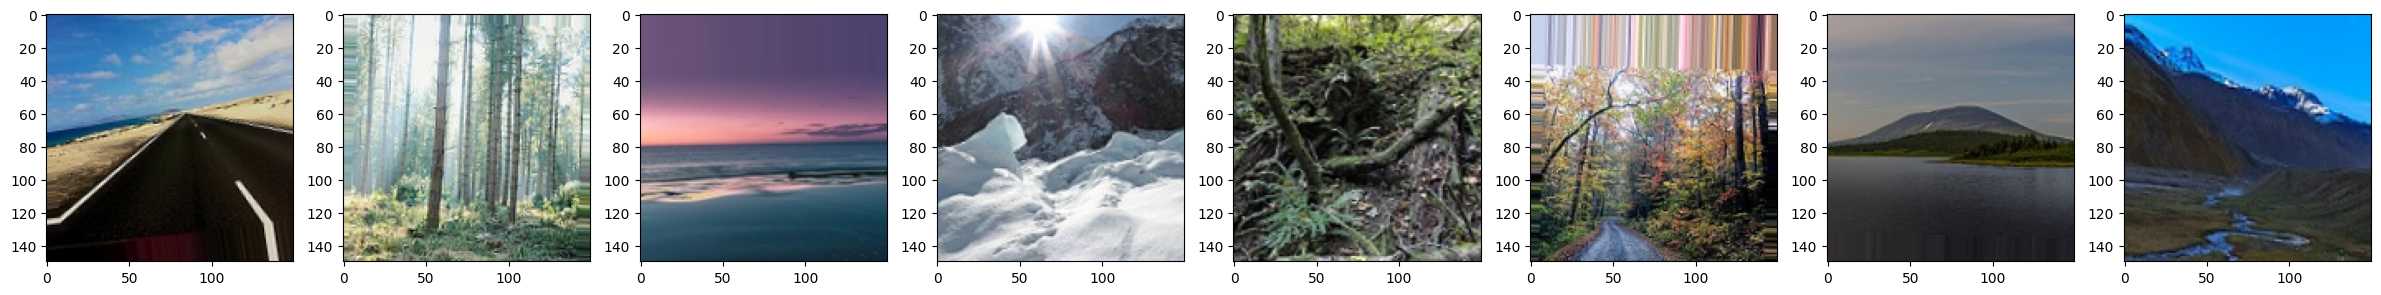

In [25]:
# Directorio donde se guardarán las imágenes aumentadas
save_dir = "augmented"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

train_generator = datagen.flow_from_directory(
							training_path,
							target_size = (150, 150),
							batch_size = 8,
							class_mode ='binary',
							save_to_dir= save_dir,
              save_prefix='aug',
              save_format='png'
							)

images , labels = train_generator[0]

print(images.shape)
print(labels)
plt.figure()
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))

for i in range(images.shape[0]) :
  axarr[i].imshow(images[i])
  
# Guardar las imágenes aumentadas
for i, _ in enumerate(train_generator): 
    if i >= 8: 
        break

In [26]:
# Cargar y codificar etiquetas para el conjunto de test
test_labels = []
for label in subfolders:
    folder_path = os.path.join(test_path, label)
    num_files = len(os.listdir(folder_path))
    test_labels.extend([label] * num_files)

test_labels = np.array(test_labels)
test_labels_encoded = label_encoder.transform(test_labels)


In [27]:
# Preprocesar imágenes de predicción
prediction_images = []
for filename in os.listdir(prediction_path):
    img_path = os.path.join(prediction_path, filename)
    if os.path.isfile(img_path):
        img = Image.open(img_path).resize((128, 128))
        img_array = np.array(img)
        prediction_images.append(img_array)

prediction_images = np.array(prediction_images)

# Normalizar imágenes de predicción
num_images_pred, height_pred, width_pred, channels_pred = prediction_images.shape
prediction_images_reshaped = prediction_images.reshape((num_images_pred, -1))
prediction_images_scaled = scaler.transform(prediction_images_reshaped)
prediction_images_scaled = prediction_images_scaled.reshape((num_images_pred, height_pred, width_pred, channels_pred))